In [1]:
import os
import gc
import glob
import pandas as pd

In [2]:
snapshot = pd.read_csv("./data/2019-Oct.csv").sample(1000)
snapshot.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
7643852,2019-10-07 01:22:13 UTC,view,5100567,2053013553341792533,electronics.clocks,apple,459.52,513944852,a6fe0ea3-2a38-405f-b33c-1b2ac8acedf2
24557269,2019-10-18 16:47:57 UTC,view,1004836,2053013555631882655,electronics.smartphone,samsung,229.22,514364299,e88d69a0-e4e3-49b9-939b-d23b1c174314
40008183,2019-10-30 01:23:43 UTC,view,5500276,2053013563139687243,NaN,xiaomi,51.18,545372328,d4643bea-1029-4fda-a722-9431081bd04d
9040899,2019-10-08 05:41:11 UTC,view,9800480,2053013554071601477,NaN,aerocool,29.73,512448294,70d355eb-cda8-48d8-96ad-c74b315aa74c
31106469,2019-10-23 08:59:20 UTC,view,1005094,2053013555631882655,electronics.smartphone,tecno,110.43,512924426,da864424-bba0-40a8-9b37-8ace54f55293


In [3]:
!mkdir data\tmp
snapshot.to_csv('./data/tmp/snapshot.csv', index=False)

A subdirectory or file data\tmp already exists.


In [4]:
gc.collect()

0

### Data Transform

In [5]:
import os
import gc
import glob
import pandas as pd
from pathlib import Path

In [6]:
file = './data/tmp/snapshot.csv'

In [7]:
df_tmp = pd.read_csv(file)
df_tmp['session_purchase'] =  df_tmp['user_session'] + '_' + df_tmp['product_id'].astype(str)
df_purchase = df_tmp[df_tmp['event_type']=='purchase']
df_cart = df_tmp[df_tmp['event_type']=='cart']
df_purchase = df_purchase[df_purchase['session_purchase'].isin(df_cart['session_purchase'])]
df_cart = df_cart[~(df_cart['session_purchase'].isin(df_purchase['session_purchase']))]
df_cart['target'] = 0
df_purchase['target'] = 1
df = pd.concat([df_cart, df_purchase])
df = df.drop('category_id', axis=1)
df = df.drop('session_purchase', axis=1)
df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,target
9,2019-10-17 08:52:39 UTC,cart,1004840,electronics.smartphone,huawei,949.26,515780411,9632de25-b93f-47f8-ac33-b87aeff89b63,0
45,2019-10-01 19:39:45 UTC,cart,1004767,electronics.smartphone,samsung,253.16,555768802,29de0a13-1925-454c-8efe-48404930ab6e,0
56,2019-10-14 18:07:38 UTC,cart,5100816,NaN,xiaomi,28.42,512421009,bd74c61d-6841-4d60-bf57-74c3bbf5c2b0,0
112,2019-10-27 07:03:43 UTC,cart,1004873,electronics.smartphone,samsung,366.60,525307791,33300e44-48f1-4505-bb18-1e579b530a46,0
152,2019-10-30 14:19:16 UTC,cart,1004856,electronics.smartphone,samsung,130.99,555003242,89783bc5-3abb-4008-96c3-657ee754b06e,0


In [8]:
df[['cat_0', 'cat_1', 'cat_2']] = df['category_code'].str.split("\.", n = 3, expand = True).fillna('NA')
# df[['cat_0', 'cat_1', 'cat_2', 'cat_3']] = df['category_code'].str.split("\.", n = 3, expand = True).fillna('NA')
df['brand'] = df['brand'].fillna('NA')
df = df.drop('category_code', axis=1)
df['timestamp'] = pd.to_datetime(df['event_time'].str.replace(' UTC', ''))
df['ts_hour'] = df['timestamp'].dt.hour
df['ts_minute'] = df['timestamp'].dt.minute
df['ts_weekday'] = df['timestamp'].dt.weekday
df['ts_day'] = df['timestamp'].dt.day
df['ts_month'] = df['timestamp'].dt.month
df['ts_year'] = df['timestamp'].dt.year
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
9,2019-10-17 08:52:39 UTC,cart,1004840,huawei,949.26,515780411,9632de25-b93f-47f8-ac33-b87aeff89b63,0,electronics,smartphone,NA,2019-10-17 08:52:39,8,52,3,17,10,2019
45,2019-10-01 19:39:45 UTC,cart,1004767,samsung,253.16,555768802,29de0a13-1925-454c-8efe-48404930ab6e,0,electronics,smartphone,NA,2019-10-01 19:39:45,19,39,1,1,10,2019
56,2019-10-14 18:07:38 UTC,cart,5100816,xiaomi,28.42,512421009,bd74c61d-6841-4d60-bf57-74c3bbf5c2b0,0,NA,NA,NA,2019-10-14 18:07:38,18,7,0,14,10,2019
112,2019-10-27 07:03:43 UTC,cart,1004873,samsung,366.60,525307791,33300e44-48f1-4505-bb18-1e579b530a46,0,electronics,smartphone,NA,2019-10-27 07:03:43,7,3,6,27,10,2019
152,2019-10-30 14:19:16 UTC,cart,1004856,samsung,130.99,555003242,89783bc5-3abb-4008-96c3-657ee754b06e,0,electronics,smartphone,NA,2019-10-30 14:19:16,14,19,2,30,10,2019


In [9]:
list_files = glob.glob('./data/*.csv')
list_files

['./data\\2019-Dec.csv',
 './data\\2019-Nov.csv',
 './data\\2019-Oct.csv',
 './data\\2020-Apr.csv',
 './data\\2020-Feb.csv',
 './data\\2020-Jan.csv',
 './data\\2020-Mar.csv']

In [10]:
def process_files(df_tmp, chunkname):
    df_tmp['session_purchase'] =  df_tmp['user_session'] + '_' + df_tmp['product_id'].astype(str)
    df_purchase = df_tmp[df_tmp['event_type']=='purchase']
    df_cart = df_tmp[df_tmp['event_type']=='cart']
    df_purchase = df_purchase[df_purchase['session_purchase'].isin(df_cart['session_purchase'])]
    df_cart = df_cart[~(df_cart['session_purchase'].isin(df_purchase['session_purchase']))]
    df_cart['target'] = 0
    df_purchase['target'] = 1
    df = pd.concat([df_cart, df_purchase])
    df = df.drop('category_id', axis=1)
    df = df.drop('session_purchase', axis=1)
    # df[['cat_0', 'cat_1', 'cat_2', 'cat_3']] = df['category_code'].str.split("\.", n = 3, expand = True).fillna('NA')
    df['brand'] = df['brand'].fillna('NA')
    # df = df.drop('category_code', axis=1)
    df['timestamp'] = pd.to_datetime(df['event_time'].str.replace(' UTC', ''))
    df['ts_hour'] = df['timestamp'].dt.hour
    df['ts_minute'] = df['timestamp'].dt.minute
    df['ts_weekday'] = df['timestamp'].dt.weekday
    df['ts_day'] = df['timestamp'].dt.day
    df['ts_month'] = df['timestamp'].dt.month
    df['ts_year'] = df['timestamp'].dt.year
    df.to_csv(chunkname, index=False)

In [11]:
base_path_silver = "./data/silver"
!mkdir data\silver

A subdirectory or file data\silver already exists.


In [12]:
for idx, chunk in enumerate(list_files[:2]):
  chunkname = os.path.join(base_path_silver, Path(chunk).stem + '-' + str(idx) + '.csv')
  print(chunkname)

./data/silver\2019-Dec-0.csv
./data/silver\2019-Nov-1.csv


In [13]:
chunksize = 10 ** 6

for file in list_files:
    print(file)
    for idx, chunk in enumerate(pd.read_csv(file, chunksize=chunksize)):
      chunkname = os.path.join(base_path_silver, Path(file).stem + '-' + str(idx) + '.csv')
      print(chunkname)
      if not os.path.exists(chunkname):
        process_files(chunk, chunkname)

./data\2019-Dec.csv
./data/silver\2019-Dec-0.csv
./data/silver\2019-Dec-1.csv
./data/silver\2019-Dec-2.csv
./data/silver\2019-Dec-3.csv
./data/silver\2019-Dec-4.csv
./data/silver\2019-Dec-5.csv
./data/silver\2019-Dec-6.csv
./data/silver\2019-Dec-7.csv
./data/silver\2019-Dec-8.csv
./data/silver\2019-Dec-9.csv
./data/silver\2019-Dec-10.csv
./data/silver\2019-Dec-11.csv
./data/silver\2019-Dec-12.csv
./data/silver\2019-Dec-13.csv
./data/silver\2019-Dec-14.csv
./data/silver\2019-Dec-15.csv
./data/silver\2019-Dec-16.csv
./data/silver\2019-Dec-17.csv
./data/silver\2019-Dec-18.csv
./data/silver\2019-Dec-19.csv
./data/silver\2019-Dec-20.csv
./data/silver\2019-Dec-21.csv
./data/silver\2019-Dec-22.csv
./data/silver\2019-Dec-23.csv
./data/silver\2019-Dec-24.csv
./data/silver\2019-Dec-25.csv
./data/silver\2019-Dec-26.csv
./data/silver\2019-Dec-27.csv
./data/silver\2019-Dec-28.csv
./data/silver\2019-Dec-29.csv
./data/silver\2019-Dec-30.csv
./data/silver\2019-Dec-31.csv
./data/silver\2019-Dec-32.csv


./data/silver\2020-Feb-26.csv
./data/silver\2020-Feb-27.csv
./data/silver\2020-Feb-28.csv
./data/silver\2020-Feb-29.csv
./data/silver\2020-Feb-30.csv
./data/silver\2020-Feb-31.csv
./data/silver\2020-Feb-32.csv
./data/silver\2020-Feb-33.csv
./data/silver\2020-Feb-34.csv
./data/silver\2020-Feb-35.csv
./data/silver\2020-Feb-36.csv
./data/silver\2020-Feb-37.csv
./data/silver\2020-Feb-38.csv
./data/silver\2020-Feb-39.csv
./data/silver\2020-Feb-40.csv
./data/silver\2020-Feb-41.csv
./data/silver\2020-Feb-42.csv
./data/silver\2020-Feb-43.csv
./data/silver\2020-Feb-44.csv
./data/silver\2020-Feb-45.csv
./data/silver\2020-Feb-46.csv
./data/silver\2020-Feb-47.csv
./data/silver\2020-Feb-48.csv
./data/silver\2020-Feb-49.csv
./data/silver\2020-Feb-50.csv
./data/silver\2020-Feb-51.csv
./data/silver\2020-Feb-52.csv
./data/silver\2020-Feb-53.csv
./data/silver\2020-Feb-54.csv
./data/silver\2020-Feb-55.csv
./data\2020-Jan.csv
./data/silver\2020-Jan-0.csv
./data/silver\2020-Jan-1.csv
./data/silver\2020-Jan

In [14]:
import os
for file in list_files:
  os.remove(file)

In [15]:
list_chunks = glob.glob(os.path.join(base_path_silver,'*.csv'))
list_chunks[:10]

['./data/silver\\2019-Dec-0.csv',
 './data/silver\\2019-Dec-1.csv',
 './data/silver\\2019-Dec-10.csv',
 './data/silver\\2019-Dec-11.csv',
 './data/silver\\2019-Dec-12.csv',
 './data/silver\\2019-Dec-13.csv',
 './data/silver\\2019-Dec-14.csv',
 './data/silver\\2019-Dec-15.csv',
 './data/silver\\2019-Dec-16.csv',
 './data/silver\\2019-Dec-17.csv']

In [16]:
!cd $base_path_silver && zip -r data_silver.zip /data/data_silver ./*.csv

	zip warning: name not matched: /data/data_silver
  adding: 2019-Dec-0.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-1.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-10.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-11.csv (172 bytes security) (deflated 77%)
  adding: 2019-Dec-12.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-13.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-14.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-15.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-16.csv (172 bytes security) (deflated 77%)
  adding: 2019-Dec-17.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-18.csv (172 bytes security) (deflated 77%)
  adding: 2019-Dec-19.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-2.csv (172 bytes security) (deflated 76%)
  adding: 2019-Dec-20.csv (172 bytes security) (deflated 77%)
  adding: 2019-Dec-21.csv (172 bytes security) (deflated 77%)
  adding: 2019-Dec-22.c

In [17]:
lp = []
for file in list_chunks:
  lp.append(pd.read_csv(file))

In [18]:
df = pd.concat(lp)
df.shape

(16742775, 16)

In [19]:
df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2019-12-01 00:00:28 UTC,cart,17800342,computers.desktop,zeta,66.90,550465671,22650a62-2d9c-4151-9f41-2674ec6d32d5,0,2019-12-01 00:00:28,0,0,6,1,12,2019
1,2019-12-01 00:00:39 UTC,cart,3701309,appliances.environment.vacuum,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,2019-12-01 00:00:39,0,0,6,1,12,2019
2,2019-12-01 00:00:40 UTC,cart,3701309,appliances.environment.vacuum,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,2019-12-01 00:00:40,0,0,6,1,12,2019
3,2019-12-01 00:00:41 UTC,cart,3701309,appliances.environment.vacuum,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,2019-12-01 00:00:41,0,0,6,1,12,2019
4,2019-12-01 00:01:56 UTC,cart,1004767,construction.tools.light,samsung,235.60,579970209,c6946211-ce70-4228-95ce-fd7fccdde63c,0,2019-12-01 00:01:56,0,1,6,1,12,2019


In [20]:
# df2.columns = ['cat_{}'.format(x+1) for x in df2.columns]
# df2.to_parquet('/content/data/silver_l2/df_cat.parquet', index=False)

In [21]:
df_test = df[df['ts_month']==4]
df_valid = df[df['ts_month']==3]
df_train = df[(df['ts_month']!=3)&(df['ts_month']!=4)]

In [22]:
df_train.shape, df_valid.shape, df_test.shape

((11495245, 16), (2466048, 16), (2781482, 16))

In [23]:
!mkdir data\silver_l2
df_train.to_parquet('./data/silver_l2/train.parquet', index=False)
df_valid.to_parquet('./data/silver_l2/valid.parquet', index=False)
df_test.to_parquet('./data/silver_l2/test.parquet', index=False)

### Data load

In [24]:
base_path_silver_l2 = "./data/silver_l2"

In [25]:
!cd $base_path_silver_l2 && zip -r data_silver_l2.zip /data/silver_l2 ./*.parquet

	zip warning: name not matched: /data/silver_l2
  adding: test.parquet (172 bytes security) (deflated 24%)
  adding: train.parquet (172 bytes security) (deflated 25%)
  adding: valid.parquet (172 bytes security) (deflated 24%)


In [26]:
import pandas as pd

df_train = pd.read_parquet('./data/silver_l2/train.parquet')
df_valid = pd.read_parquet('./data/silver_l2/valid.parquet')
df_test = pd.read_parquet('./data/silver_l2/test.parquet')

df = pd.concat([df_train, df_valid, df_test],ignore_index=True)

df.shape

(16742775, 16)

### EDA

In [27]:
import IPython

import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [28]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
target             int64
timestamp         object
ts_hour            int64
ts_minute          int64
ts_weekday         int64
ts_day             int64
ts_month           int64
ts_year            int64
dtype: object

In [29]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [30]:
df.target.mean()

0.36775719676099095

In [31]:
df['event_type'].value_counts(normalize=True)

cart        0.632243
purchase    0.367757
Name: event_type, dtype: float64

Around 30% of datapoints are purchases. Lets take a look on the sparsity of the data.

In [32]:
print('# of datapoints:' + str(df.shape))
print('# of unique users:' + str(df['user_id'].drop_duplicates().shape))
print('# of unique products:' + str(df['product_id'].drop_duplicates().shape))
print('# of unique sessions:' + str(df['user_session'].drop_duplicates().shape))

# of datapoints:(16742775, 16)
# of unique users:(3584809,)
# of unique products:(214907,)
# of unique sessions:(10715053,)


In [33]:
def plot_sparse(df, col):
    stats = df[[col, 'target']].groupby(col).agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats_sort = stats['count'].value_counts().reset_index()
    stats_sort = stats_sort.sort_values('index')
    plt.figure(figsize=(15,4))
    plt.bar(stats_sort['index'].astype(str).values[0:20], stats_sort['count'].values[0:20])
    plt.title('Frequency of ' + str(col))
    plt.xlabel('Number frequency')
    plt.ylabel('Frequency')

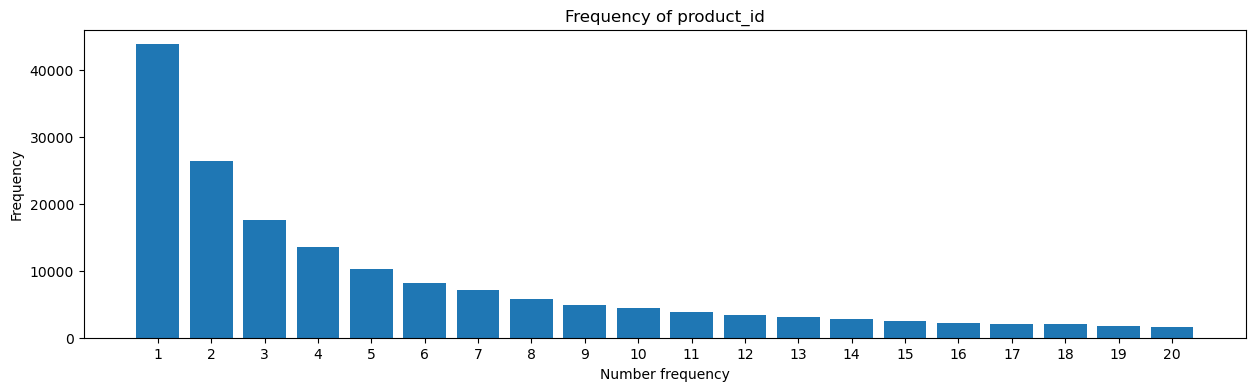

In [34]:
plot_sparse(df, 'product_id')

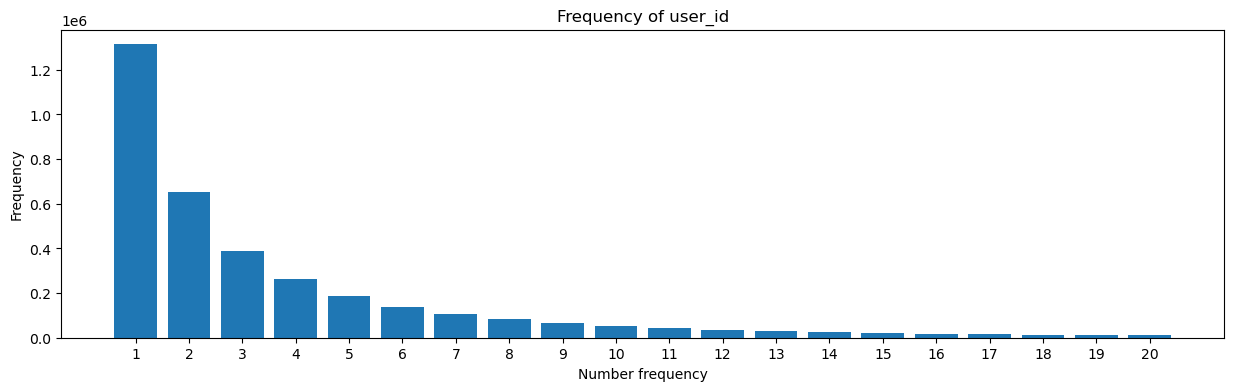

In [35]:
plot_sparse(df, 'user_id')

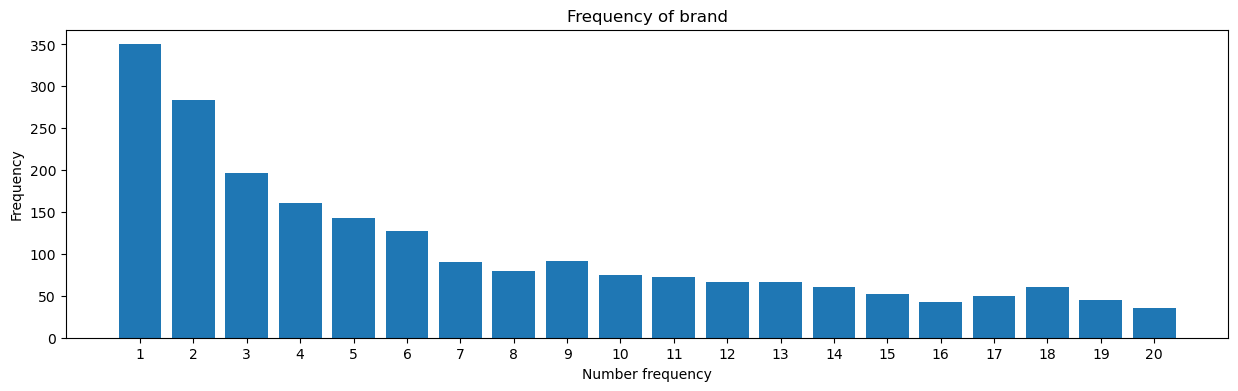

In [36]:
plot_sparse(df, 'brand')

We can observe following pattern:

There are 46000 products appear only once in the dataset
There are 1200000 users appear only once in the dataset
There are 350 brands appear only once in the dataset
Product_id and User_id have many values which appear only once and the model is less able to learn. Brands is better to be leveraged for prediction.

In [37]:
def plot_top20(df, col):
    stats = df[[col, 'target']].groupby(col).agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats = stats.sort_values('count', ascending=False)
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax2 = ax1.twinx()
    ax1.bar(stats[col].astype(str).values[0:20], stats['count'].values[0:20])
    ax1.set_xticklabels(stats[col].astype(str).values[0:20], rotation='vertical')
    ax2.plot(stats['mean'].values[0:20], color='red')
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Mean Target')
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(col)
    ax1.set_title('Top20 ' + col + 's based on frequency')

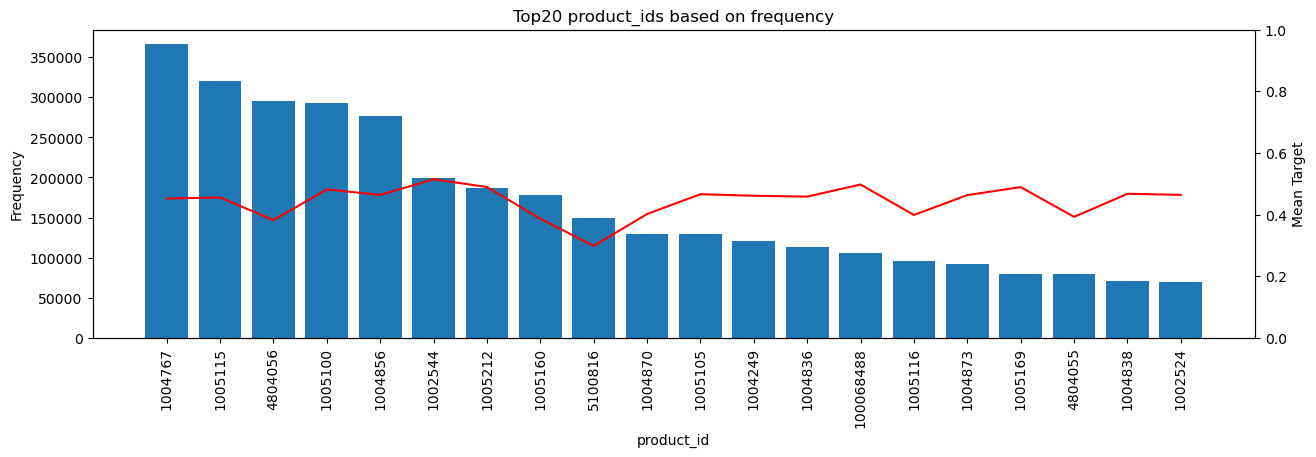

In [38]:
plot_top20(df, 'product_id')

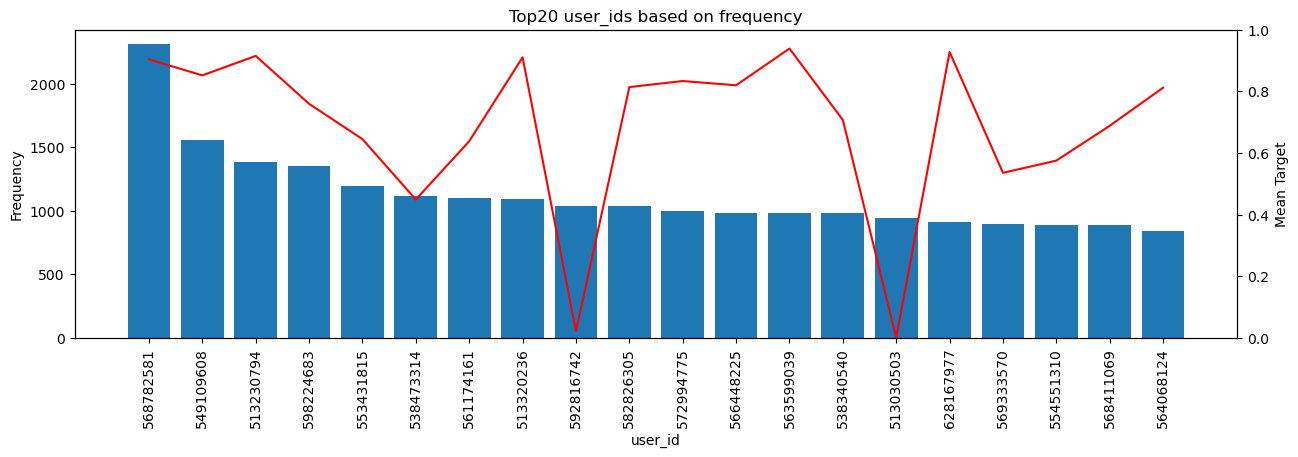

In [39]:
plot_top20(df, 'user_id')

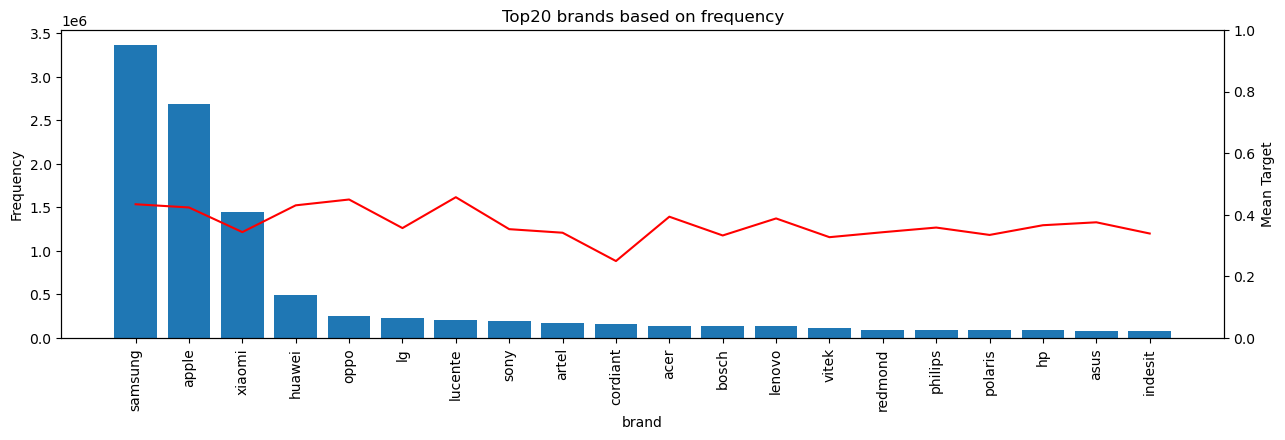

In [40]:
plot_top20(df, 'brand')

In [41]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date

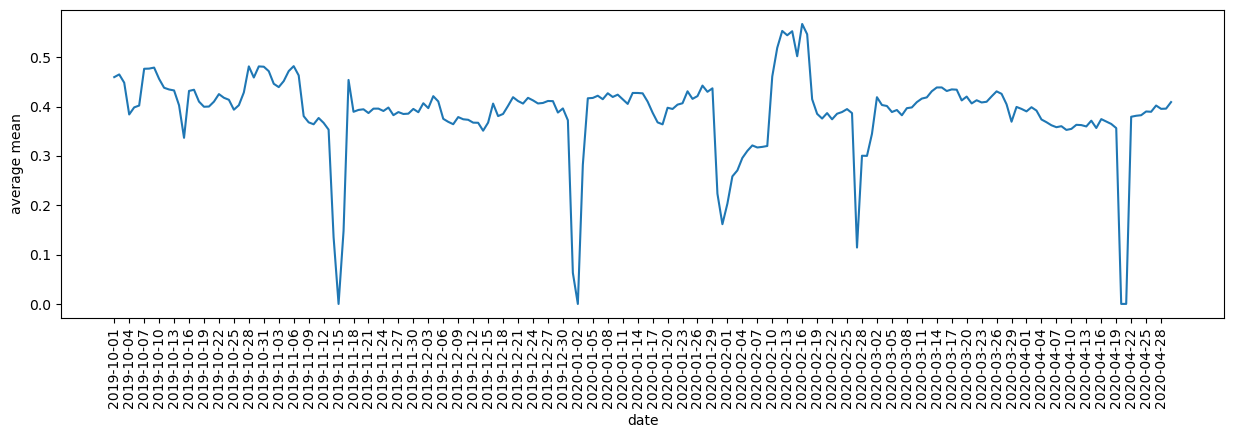

In [42]:
plt.figure(figsize=(15,4))
plt.plot(df[['date', 'target']].groupby('date').target.mean())
plt.ylabel('average mean')
plt.xlabel('date')
plt.xticks(df[['date', 'target']].groupby('date').target.mean().index[::3], rotation='vertical')
print('')

In [43]:
df[['date', 'target']].groupby('date').target.mean().sort_values().head(20)

date
2019-11-15    0.000000
2020-01-02    0.000000
2020-04-20    0.000096
2020-04-21    0.000147
2020-01-01    0.063013
2020-02-27    0.114378
2019-11-14    0.135596
2019-11-16    0.147902
2020-01-31    0.161678
2020-02-01    0.203322
2020-01-30    0.223492
2020-02-02    0.258615
2020-02-03    0.270665
2020-01-03    0.282014
2020-02-04    0.295918
2020-02-29    0.300146
2020-02-28    0.300432
2020-02-05    0.310188
2020-02-07    0.317174
2020-02-08    0.318376
Name: target, dtype: float64

- We explored the data and saw the different raw features in the dataset.
- We analzyed basic statistics of the raw features and saw long-tail distribution for categorical features (user, item, brand)
- Some categorical features have high occurances
- Categorical features have variance which we can leverage to engineer more powerful features
